<a href="https://colab.research.google.com/github/marcusmvfa/Covid-19Forecast/blob/main/CovidForecastTCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primeiro Seleciono os arquivos com os dados

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean


In [246]:
# file = tf.keras.utils.get_file(origin="https://raw.githubusercontent.com/marcusmvfa/Covid-19Forecast/main/soFoize.csv",fname='soFoize.csv', extract=True)

# df = pd.read_csv(Teste1, sep=',',encoding='UTF-8', error_bad_lines=False, infer_datetime_format=True)

# df['date'] = pd.to_datetime(df['date'])

# df = df.drop(columns=['epi_week', 'last_info_date', '_source', 'country','state','city', 'date'])


In [6]:
file = tf.keras.utils.get_file(origin="https://raw.githubusercontent.com/marcusmvfa/Covid-19Forecast/main/soFoize.csv",fname='soFoize.csv', extract=True)

df = pd.read_csv(file, sep=',',encoding='UTF-8', error_bad_lines=False, infer_datetime_format=True)
df['date'] = pd.to_datetime(df['date'])  
# mask = df['date'] <= '2020-12-18'
# df = df.loc[mask]
df = df.drop(columns=['epi_week', 'last_info_date', '_source', 'country','state','city'])
# df["date"] = pd.to_datetime(df["date"])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
# df.drop(columns=['epi_week'])
df.head()
df.dtypes

date                               datetime64[ns]
ibgeID                                      int64
newDeaths                                   int64
deaths                                      int64
newCases                                    int64
totalCases                                  int64
deaths_per_100k_inhabitants               float64
totalCases_per_100k_inhabitants           float64
deaths_by_totalCases                      float64
dtype: object

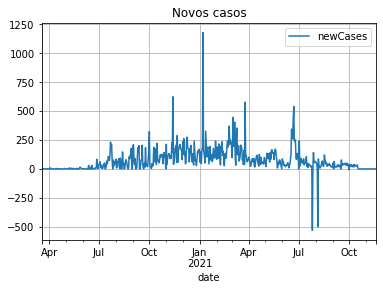

In [9]:
df.plot(x='date', y=['newCases'],title='Novos casos',grid=True);

# df.loc[df.index == 505, 'newCases'] = 500


In [28]:
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

train_visu, test_visu = train_test_split(df, test_size=0.3, shuffle=False)
train_visu

,date,ibgeID,newDeaths,deaths,newCases,totalCases,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases
0,2020-03-18,4108304,0,0,1,1,0.00000,0.38764,0.00000
1,2020-03-19,4108304,0,0,0,1,0.00000,0.38764,0.00000
2,2020-03-20,4108304,0,0,0,1,0.00000,0.38764,0.00000
3,2020-03-21,4108304,0,0,0,1,0.00000,0.38764,0.00000
4,2020-03-22,4108304,0,0,3,4,0.00000,1.55056,0.00000
...,...,...,...,...,...,...,...,...,...
424,2021-05-16,4108304,17,797,141,36611,308.94946,14191.90529,0.02177
425,2021-05-17,4108304,1,798,80,36691,309.33710,14222.91653,0.02175
426,2021-05-18,4108304,5,803,148,36839,311.27530,14280.28732,0.02180
427,2021-05-19,4108304,3,806,171,37010,312.43822,14346.57384,0.02178


In [30]:
fig = go.Figure()
fig.add_scattergl(x=train_visu.date, y=train_visu.newCases, line={'color': 'royalblue'}, name='treino')
fig.add_scattergl(x=test_visu.date, y=test_visu.newCases, line={'color': 'orangered'}, name='teste')
fig.update_layout(
    title="Divisão do dataset de casos diários em 70% treino e 30% teste",
    xaxis_title="data",
    yaxis_title="casos diários",
    font=dict(
        size=12,
    )
)
fig.show()

**Novo modelo de GRU**

Imports

In [31]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
import numpy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math

In [32]:
# Cria o DataSet
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [33]:
# Semente do aleatório fixada
numpy.random.seed(7)

In [34]:
# Seta os dados
dataset = df['newCases'].values
dataset = dataset.astype('float32')

In [35]:
# Normaliza para facilitar nos calculos,  entre 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

In [36]:
# Separação entre Treino e Teste
train_fraction = 0.70
train_size = int(len(dataset) * train_fraction)
test_size = len(dataset) - train_size
Treino, Teste = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [37]:
# Reshape para X=t e Y=t+1
look_back = 20
TreinoX, TreinoY = create_dataset(Treino, look_back)
testX, testY = create_dataset(Teste, look_back)
TreinoX = numpy.reshape(TreinoX, (TreinoX.shape[0], TreinoX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [38]:
model = Sequential()
model.add(GRU(units=16, input_shape=(look_back, 1), return_sequences=True))
model.add(GRU(units=32, return_sequences=True))
model.add(GRU(units=64))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 16)            912       
                                                                 
 gru_1 (GRU)                 (None, 20, 32)            4800      
                                                                 
 gru_2 (GRU)                 (None, 64)                18816     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 24,593
Trainable params: 24,593
Non-trainable params: 0
_________________________________________________________________


In [39]:
start_time = datetime.now()
history = model.fit(TreinoX, TreinoY, epochs = 300, batch_size = 10)
final_time = datetime.now()

Epoch 1/300
41/41 [==============================] - 7s 28ms/step - loss: 0.0151
Epoch 2/300
41/41 [==============================] - 1s 27ms/step - loss: 0.0029
Epoch 3/300
41/41 [==============================] - 1s 27ms/step - loss: 0.0028
Epoch 4/300
41/41 [==============================] - 1s 28ms/step - loss: 0.0028
Epoch 5/300
41/41 [==============================] - 1s 27ms/step - loss: 0.0028
Epoch 6/300
41/41 [==============================] - 1s 27ms/step - loss: 0.0030
Epoch 7/300
41/41 [==============================] - 1s 27ms/step - loss: 0.0027
Epoch 8/300
41/41 [==============================] - 1s 28ms/step - loss: 0.0028
Epoch 9/300
41/41 [==============================] - 1s 28ms/step - loss: 0.0031
Epoch 10/300
41/41 [==============================] - 1s 27ms/step - loss: 0.0030
Epoch 11/300
41/41 [==============================] - 1s 27ms/step - loss: 0.0031
Epoch 12/300
41/41 [==============================] - 1s 28ms/step - loss: 0.0027
Epoch 13/300
41/41 [=====

In [40]:
aux = final_time - start_time
print(aux.total_seconds()/60)

5.7918943333333335


In [41]:
y_ajustado = model.predict(TreinoX)
aux1 = TreinoY
aux2 = y_ajustado[:,0]
y_predito = model.predict(testX)
aux3 = testY
aux4 = y_predito[:,0]

In [43]:
fig = go.Figure()
fig.add_scattergl(x=train_visu.date, y=aux1, line={'color': 'royalblue'}, name='treino')
fig.add_scattergl(x=train_visu.date, y=aux2, line={'color': 'orangered'}, name='ajuste_treino')
fig.show()

In [45]:
fig = go.Figure()
fig.add_scattergl(x=test_visu.date, y=aux3, line={'color': 'royalblue'}, name='teste')
fig.add_scattergl(x=test_visu.date, y=aux4, line={'color': 'orangered'}, name='previsão')
fig.show()

In [46]:
# Predizer os dados
trainPredict = model.predict(TreinoX)
testPredict = model.predict(testX)

In [47]:
# Volta escapa original para Plotar
trainPredict = scaler.inverse_transform(trainPredict)
TreinoY = scaler.inverse_transform([TreinoY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [48]:
# Criando vetores de train e teste preditos para plotar
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [50]:
fig = go.Figure()
fig.add_scattergl(x=df.date, y=df.newCases, line={'color': 'royalblue'}, name='valores reais')
fig.add_scattergl(x=df.date, y=trainPredictPlot[:,0], line={'color': 'green'}, name='ajuste_treino')
fig.add_scattergl(x=df.date, y=testPredictPlot[:,0], line={'color': 'orangered'}, name='previsão')
fig.show()

In [51]:
print('Resultados treino')
# Calculo do Erro Absoluto Médio (MAE) e apresenta o resultado
trainScore = mean_absolute_error(TreinoY[0], trainPredict[:,0])
print('MAE: %.2f' % (trainScore))

# Calculo da Raiz do Erro Médio Quadrado (RMSE) e apresenta o resultado
trainScore = math.sqrt(mean_squared_error(TreinoY[0], trainPredict[:,0]))
print('RMSE: %.2f' % (trainScore))

# Calculo do r2_score e apresenta o resultado
trainScore = r2_score(TreinoY[0], trainPredict[:,0])
print('r2_score: %.2f' % (trainScore))

print()

print('Resultados teste')
# Calculo do Erro Absoluto Médio (MAE) e apresenta o resultado
testScore = mean_absolute_error(testY[0], testPredict[:,0])
print('MAE: %.2f' % (testScore))

# Calculo da Raiz do Erro Médio Quadrado (RMSE) e apresenta o resultado
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('RMSE: %.2f' % (testScore))

# Calculo do r2_score e apresenta o resultado
testScore = r2_score(testY[0], testPredict[:,0])
print('r2_score: %.2f' % (testScore))

Resultados treino
MAE: 38.64
RMSE: 75.80
r2_score: 0.45

Resultados teste
MAE: 54.77
RMSE: 112.15
r2_score: -0.33


**Fim do novo modelo de GRU**

In [10]:
target_name = ['newCases']

In [11]:
shift_steps = 30

In [12]:
df_targets = df[target_name].shift(-shift_steps)


In [13]:
df_targets

,newCases
0,0.0
1,3.0
2,-1.0
3,0.0
4,0.0
...,...
608,NaN
609,NaN
610,NaN
611,NaN


In [14]:
df[target_name].head(shift_steps + 5)

,newCases
0,1
1,0
2,0
3,0
4,3
5,0
6,0
7,1
8,0
9,0


In [15]:
df_targets.head(5)

,newCases
0,0.0
1,3.0
2,-1.0
3,0.0
4,0.0


In [16]:
df_targets.tail()


,newCases
608,NaN
609,NaN
610,NaN
611,NaN
612,NaN


In [17]:
x_data = df.values[0:-shift_steps]
x_data


array([[Timestamp('2020-03-18 00:00:00'), 4108304, 0, ..., 0.0, 0.38764,
        0.0],
       [Timestamp('2020-03-19 00:00:00'), 4108304, 0, ..., 0.0, 0.38764,
        0.0],
       [Timestamp('2020-03-20 00:00:00'), 4108304, 0, ..., 0.0, 0.38764,
        0.0],
       ...,
       [Timestamp('2021-10-19 00:00:00'), 4108304, 0, ...,
        450.05059000000006, 17421.7257, 0.02583],
       [Timestamp('2021-10-20 00:00:00'), 4108304, 0, ...,
        450.05059000000006, 17421.7257, 0.02583],
       [Timestamp('2021-10-21 00:00:00'), 4108304, 0, ...,
        450.05059000000006, 17421.7257, 0.02583]], dtype=object)

In [18]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (583, 9)


In [19]:
y_data = df_targets.values[:-shift_steps]


In [20]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (583, 1)


Número de observações

In [21]:
num_data = len(x_data)
num_data

583

In [262]:
train_split = 0.7

In [263]:
num_train = int(train_split * num_data)
num_train

408

In [264]:
num_test = num_data - num_train
num_test

175

In [265]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

583

In [266]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

583

In [267]:
num_x_signals = x_data.shape[1]
num_x_signals

8

In [268]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [269]:
df.dtypes

ibgeID                               int64
newDeaths                            int64
deaths                               int64
newCases                             int64
totalCases                           int64
deaths_per_100k_inhabitants        float64
totalCases_per_100k_inhabitants    float64
deaths_by_totalCases               float64
dtype: object

In [270]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -2.0
Max: 4108304.0


In [271]:
x_scaler = MinMaxScaler()


In [272]:
x_train_scaled = x_scaler.fit_transform(x_train)


In [273]:

print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [274]:
x_test_scaled = x_scaler.transform(x_test)


In [275]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [276]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(408, 8)
(408, 1)


In [277]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [278]:
batch_size = 256


In [279]:
sequence_length = 30 * 2
sequence_length

60

In [280]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [281]:
x_batch, y_batch = next(generator)


In [282]:
print(x_batch.shape)
print(y_batch.shape)

(256, 60, 8)
(256, 60, 1)


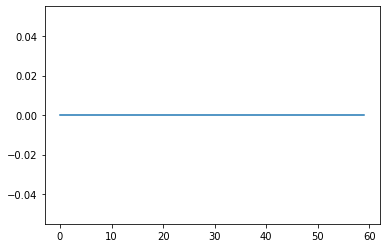

In [283]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

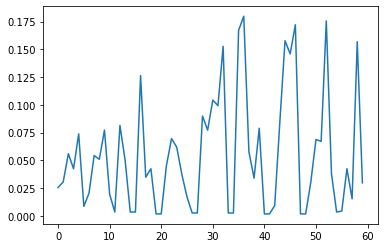

In [284]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [285]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [286]:
model = Sequential()


In [287]:
# if False:
model.add(GRU(units=512,
            return_sequences=True,
            input_shape=(None, num_x_signals,)))
if False:
  model.add(SimpleRNN(4, input_shape=(None, num_x_signals)))
  

In [288]:
model.add(Dense(num_y_signals, activation='sigmoid'))


In [289]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [290]:
warmup_steps = 50


In [291]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [292]:
optimizer = RMSprop(lr=1e-3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [293]:
# model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.compile(loss='mse')

In [294]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, None, 512)         801792    
                                                                 
 dense_4 (Dense)             (None, None, 1)           513       
                                                                 
Total params: 802,305
Trainable params: 802,305
Non-trainable params: 0
_________________________________________________________________


In [295]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [296]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [297]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [298]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [299]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [300]:
%%time
model.fit(x=generator,
          epochs=25,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)


Epoch 1/25
100/100 [==============================] - ETA: 0s - loss: 0.0126
Epoch 1: val_loss improved from inf to 0.00671, saving model to 23_checkpoint.keras
100/100 [==============================] - 167s 2s/step - loss: 0.0126 - val_loss: 0.0067 - lr: 0.0010
Epoch 2/25
100/100 [==============================] - ETA: 0s - loss: 0.0067
Epoch 2: val_loss did not improve from 0.00671

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 163s 2s/step - loss: 0.0067 - val_loss: 0.0078 - lr: 0.0010
Epoch 3/25
100/100 [==============================] - ETA: 0s - loss: 0.0061
Epoch 3: val_loss did not improve from 0.00671

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001.
100/100 [==============================] - 163s 2s/step - loss: 0.0061 - val_loss: 0.0069 - lr: 1.0000e-04
Epoch 4/25
100/100 [==============================] - ETA: 0s - loss: 0.0059
Epoch 4: val_loss did not improve from 0.00671
100/100 [=====

In [301]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [302]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 57ms/step - loss: 0.0067


In [303]:
print("loss (test-set):", result)


loss (test-set): 0.006713439244776964


In [304]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_name)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_name[signal])
        plt.legend()
        plt.show()

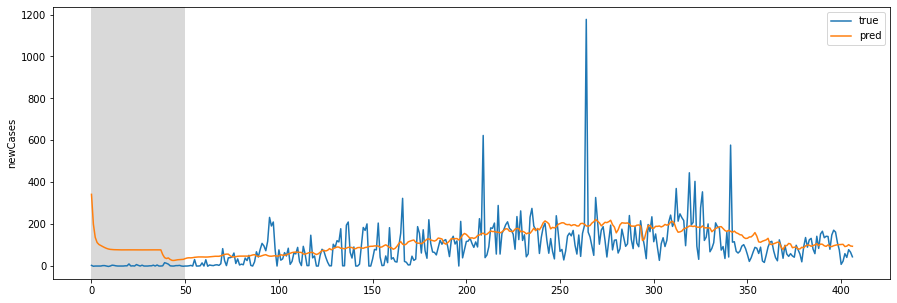

In [305]:
plot_comparison(start_idx=1, length=1000, train=True)
